In [2]:
#v2 soft hard voting
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

modelv2b0 = load_model('H:\\article\\modelstrainedv2test1-701515\\efficientnetv2b0best.h5')
modelv2b1 = load_model('H:\\article\\modelstrainedv2test1-701515\\efficientnetv2b1best.h5')
modelv2b2 = load_model('H:\\article\\modelstrainedv2test1-701515\\efficientnetv2b2best.h5')
modelv2b3 = load_model('H:\\article\\modelstrainedv2test1-701515\\efficientnetv2b3best.h5')
modelv2bS = load_model('H:\\article\\modelstrainedv2test1-701515\\efficientnetv2bsbest.h5')

base_input_shapev2b0 = modelv2b0.input_shape[1:]
base_input_shapev2b1 = modelv2b1.input_shape[1:]
base_input_shapev2b2 = modelv2b2.input_shape[1:]
base_input_shapev2b3 = modelv2b3.input_shape[1:]
base_input_shapev2bs = modelv2bS.input_shape[1:]

C:\Users\mahdi\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Found 1182 files belonging to 2 classes.
74/74 [==============================] - 797s 11s/step


Unweighted Averaging Results:

Metrics:
Accuracy: 0.9958
Precision: 0.9975
Recall: 0.9963
F1-Score: 0.9969


Max Voting Results:

Metrics:
Accuracy: 0.9949
Precision: 0.9963
Recall: 0.9963
F1-Score: 0.9963
Confusion Matrix for Unweighted Averaging:


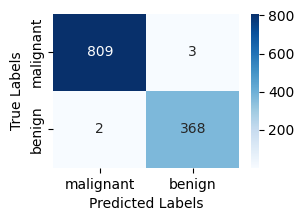

misclassified filenames:
H:\article\1\test\benign\SOB_B_A-14-22549AB-400-017.png
H:\article\1\test\benign\SOB_B_A-14-22549G-200-005.png
H:\article\1\test\malignant\SOB_M_DC-14-3909-100-026.png
H:\article\1\test\malignant\SOB_M_MC-14-10147-200-004.png
H:\article\1\test\malignant\SOB_M_MC-14-18842D-100-012.png
Confusion Matrix for Max Voting:


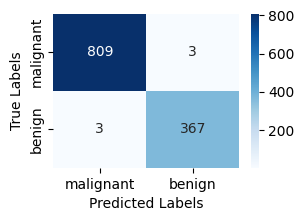

misclassified filenames:
H:\article\1\test\benign\SOB_B_A-14-22549AB-400-017.png
H:\article\1\test\benign\SOB_B_A-14-22549G-200-005.png
H:\article\1\test\benign\SOB_B_PT-14-21998AB-40-057.png
H:\article\1\test\malignant\SOB_M_DC-14-3909-100-026.png
H:\article\1\test\malignant\SOB_M_MC-14-10147-200-004.png
H:\article\1\test\malignant\SOB_M_MC-14-18842D-100-012.png


In [3]:
import numpy as np
from scipy.stats import mode
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

batch_size = 16


test_ds = image_dataset_from_directory(
    directory="H:\\article\\1\\test",  
    image_size=(256, 256),  
    batch_size=batch_size,
    shuffle=False,
)


y_true = np.concatenate([y for x, y in test_ds], axis=0)  # True labels


models = [
    
    (modelv2b0, base_input_shapev2b0),
    (modelv2b1, base_input_shapev2b1),
    (modelv2b2, base_input_shapev2b2),
    (modelv2b3, base_input_shapev2b3),
    (modelv2bS, base_input_shapev2bs),
]



def resize_dataset(dataset, target_size):
    def resize_image(image, label):
        image = tf.image.resize(image, target_size)
        return image, label
    return dataset.map(resize_image)


def get_predictions(models, test_ds):
    predictions = []
    for model, input_shape in models:
        
        resized_ds = resize_dataset(test_ds, input_shape[:2])
        y_pred = model.predict(resized_ds)  
        predictions.append(y_pred)
    return np.array(predictions)  


all_predictions = get_predictions(models, test_ds)


def unweighted_averaging(predictions):
    avg_predictions = np.mean(predictions, axis=0) 
    final_predictions = np.argmax(avg_predictions, axis=1) 
    return final_predictions


def max_voting(predictions):
    class_predictions = np.argmax(predictions, axis=2)  
    final_predictions, _ = mode(class_predictions, axis=0)
    return final_predictions.flatten()


y_pred_avg = unweighted_averaging(all_predictions)  
y_pred_vote = max_voting(all_predictions)  


print("\n\nUnweighted Averaging Results:")
accuracy = accuracy_score(y_true, y_pred_avg)
precision = precision_score(y_true, y_pred_avg, average='binary')
recall = recall_score(y_true, y_pred_avg, average='binary')
f1 = f1_score(y_true, y_pred_avg, average='binary')
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


print("\n\nMax Voting Results:")
accuracy = accuracy_score(y_true, y_pred_vote)
precision = precision_score(y_true, y_pred_vote, average='binary')
recall = recall_score(y_true, y_pred_vote, average='binary')
f1 = f1_score(y_true, y_pred_vote, average='binary')
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
#
desired_class_order = ['malignant', 'benign']

def plot_confusion_matrix(y_true, y_pred, class_names,title):
    cm = confusion_matrix(y_true, y_pred)
    current_class_order = test_ds.class_names
    order_mapping = [current_class_order.index(cls) for cls in desired_class_order]
    cm_reordered = cm[order_mapping, :][:, order_mapping]

    plt.figure(figsize=(3, 2))
    sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues', 
            xticklabels=desired_class_order, 
            yticklabels=desired_class_order)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    #plt.title(title)
    plt.show()



print("Confusion Matrix for Unweighted Averaging:")
plot_confusion_matrix(y_true, y_pred_avg, test_ds.class_names,title='Confusion Matrix EfficientNetV2_Unweighted Averaging')
misclassified_indices = np.where(y_true != y_pred_avg)[0]
file_paths = test_ds.file_paths 
misclassified_files = [file_paths[i] for i in misclassified_indices]

print("misclassified filenames:")
for file in misclassified_files:
    print(file)

print("Confusion Matrix for Max Voting:")
plot_confusion_matrix(y_true, y_pred_vote, test_ds.class_names,title='Confusion Matrix EfficientNetV2_Maximum Voting')
misclassified_indices = np.where(y_true !=  y_pred_vote)[0]
file_paths = test_ds.file_paths 
misclassified_files = [file_paths[i] for i in misclassified_indices]

print("misclassified filenames:")
for file in misclassified_files:
    print(file)
##